Dataset used in this notebook was created by "Satoshi Datamoto". It could be found on kaggle website, however it is no longer avalible.

link to the non existing dataset: https://www.kaggle.com/datasets/satoshidatamoto/crowdflower-brands-and-products-emotion-datasete/downlsatoshidatamotooad/lrnQl6c3hXt2j5LWa0m1%2Fversions%2FmoYF6rd8AS3WvnQw0hS3%2Ffiles%2Fjudge-1377884607_tweet_product_company.csv?datasetVersionNumber=2

# Brands and products emotion dataset analisys 

In [148]:
#Importing important stuff

import nltk
import sklearn
import string
import re
import keras

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [149]:
#Loading in dataset
path_to_dataset = 'tweets.csv'
df = pd.read_csv(path_to_dataset, dtype=str)

In [150]:
df = df.rename(columns = {'emotion_in_tweet_is_directed_at':'products', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotions'})
df = df.set_index('index')

## Entry analisys

In [151]:
df.describe()

,tweet_text,products,emotions
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [152]:
df.head()

,tweet_text,products,emotions
index,,,
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:ylabel='emotions'>

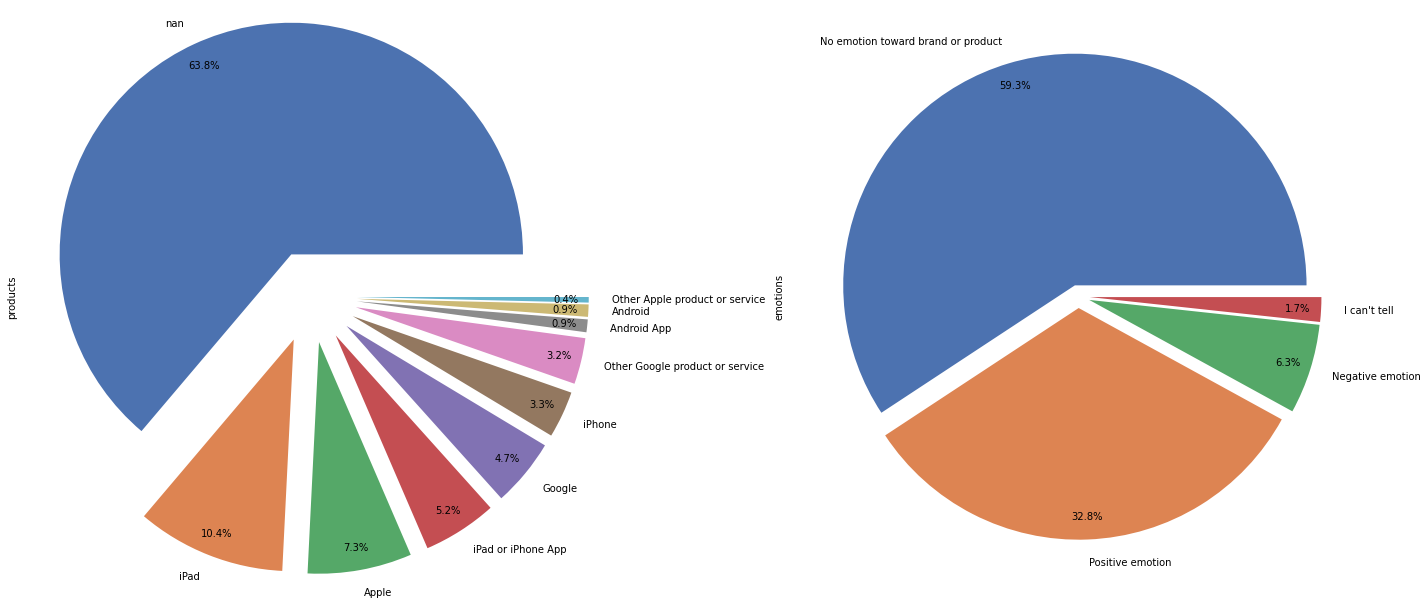

In [153]:
products= df['products'].value_counts(dropna=False)
emotions=df['emotions'].value_counts(dropna=False)

distance = [0.2 for i in products]
labels = ['' for i in products]
colors = sns.color_palette('deep')

fig = plt.figure(figsize=(20,20))


fig.add_subplot(1,2,1)
ax = products.plot.pie(autopct='%1.1f%%', colors=colors, explode=distance, grid=False, pctdistance=0.90)

fig.add_subplot(1,2,2)
ax3 = df.emotions.value_counts(dropna=False)
distanceEmotions = [0.05 for i in ax3]
ax3.plot.pie(autopct='%1.1f%%', colors=colors, explode=distanceEmotions, grid=False, pctdistance=0.90)

fig.tight_layout()
plt.show()

As we can see, there is a lot of unassigned data, in both emotions and products columns. It is an undesirable state of the dataset because unassigned data is useless if we are willing to use supervised learning algorithms for machine learning. Unbalanced data is also a problem, especially in the 'Emotions' column – we can see an overwhelming amount of one feature in the dataset. 
If we would try to train an ML model on unbalanced data, we would overfit it to classify most of the occurrences of the dominant feature.
 
What can we do to prevent such a thing? Well, we can balance our data set.

Basically, in this case, we will try to match the size of the smallest feature in our data set. In the case of the 'Emotions' column that would mean fitting the size of the 'Positive emotion' feature to the size of the 'Negative emotion' feature. Quick math: 6.3% of 9093 is 572, which means that we should only use 572 examples from 'Positive Emotions' (we don't want to use 'No Emotions' because this won't help us with determinating if a tweet is positive or negative, neither 'Can't tell' column will help us with this task).

This is not a lot of data to go off from, however, there are some ML algorithms that could do just fine with this amount.

In [154]:
throw_away = df.loc[df.emotions.isin(["No emotion toward brand or product","I can't tell"])].index
df.drop(throw_away, inplace=True)

emotions_count = df.emotions.value_counts()
procentage = int(100 - (emotions_count[1]*100)/emotions_count[0]) * 0.01

positive_emotion  = df.loc[df['emotions'] == "Positive emotion"]
index_possitive = positive_emotion.sample(frac=procentage).index
df.drop(index_possitive, inplace=True)

In [155]:
#Creating additional data for more information
df["tweet_length"] = df["tweet_text"].apply(lambda x: len(x))
df["one_hot_vector"] = df["emotions"].apply(lambda x: 1 if x == "Positive emotion" else 0)
df["punctuation"] = df["tweet_text"].apply(lambda x: x.count('!' or '.' or '?'))

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:ylabel='emotions'>

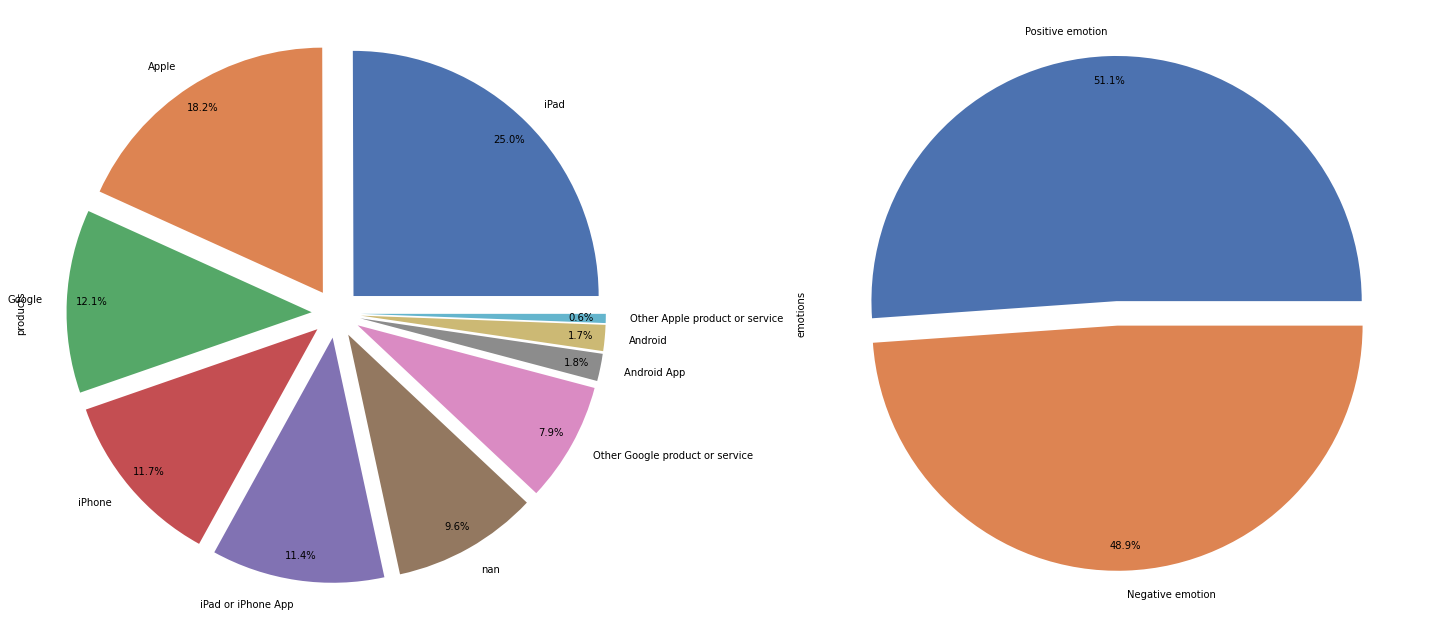

In [156]:
products=df['products'].value_counts(dropna=False)
emotions=df['emotions'].value_counts(dropna=False)

distance = [0.1 for i in products]
labels = ['' for i in products]
colors = sns.color_palette('deep')

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,2,1)
ax = products.plot.pie(autopct='%1.1f%%', colors=colors, explode=distance, grid=False, pctdistance=0.90)


fig.add_subplot(1,2,2)
ax3 = df.emotions.value_counts(dropna=False)
distanceEmotions = [0.05 for i in ax3]
ax3.plot.pie(autopct='%1.1f%%', colors=colors, explode=distanceEmotions, grid=False, pctdistance=0.90)

fig.tight_layout()
plt.show()

This looks better! Now we can further analyse newly created features to see if there is any correlation between the length of a tweet and its emotional expression. We'll do the same with punctiuation count of the tweets.

<Figure size 720x720 with 0 Axes>

[Text(0, 0.5, 'tweet_length'),
 Text(0, 1.5, 'one_hot_vector'),
 Text(0, 2.5, 'punctuation')]

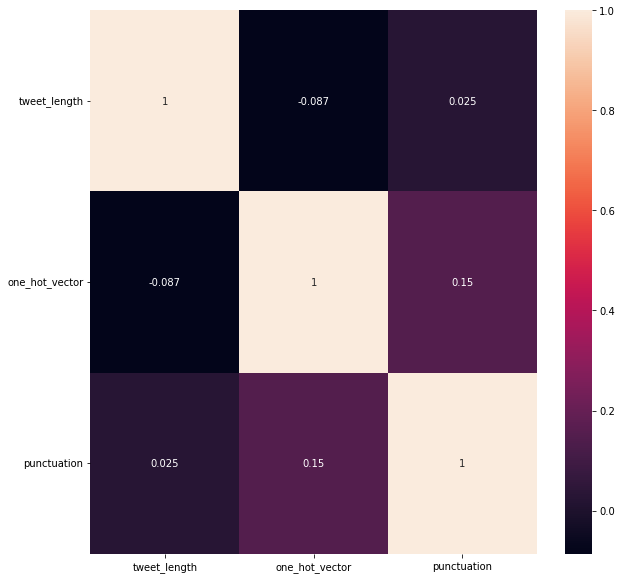

In [157]:
plt.figure(figsize=(10,10))
hm = sns.heatmap(df.corr(), annot = True)
hm.set_yticklabels(hm.get_yticklabels(), rotation=0, horizontalalignment='right')
plt.show()

There is close to none apparent correlation between a tweet's length nor the number of punctuations contained in it, and its emotional outlook. We can drop those tables because they wont bring a lot of additional information to learn from.

In [158]:
df = df.drop(["tweet_length", "punctuation"], axis=1)

Let's see how many different products positive and negative tweets describe.

In [159]:
df["products"].loc[df.emotions == "Positive emotion"].value_counts()

iPad                               167
Apple                              117
Google                              73
iPad or iPhone App                  70
Other Google product or service     45
iPhone                              33
Android App                         13
Android                             12
Other Apple product or service       5
Name: products, dtype: int64

In [160]:
df["products"].loc[df.emotions == "Negative emotion"].value_counts()

iPad                               125
iPhone                             103
Apple                               95
Google                              68
iPad or iPhone App                  63
Other Google product or service     47
Android                              8
Android App                          8
Other Apple product or service       2
Name: products, dtype: int64

Not ideal but pretty similar.

Now let's prepare our dataset to be used in ML algorithms.

## Text normalization

In [161]:
dfRaw = df.copy()
df.tweet_text = df.tweet_text.astype(str)

In [162]:
def cleanseText(textColumn):
    textColumn = textColumn.apply(lambda x: re.sub(".iphone.|.ipad.|.google.|.app.|.android.|.samsung.","",x))
    textColumn = textColumn.apply(lambda x: re.sub("@\w+","",x))
    textColumn = textColumn.apply(lambda x: re.sub(r'\w*\d+\w*','',x))
    textColumn = textColumn.apply(lambda x: re.sub(r'{link}','',x))
    textColumn = textColumn.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    textColumn = textColumn.apply(lambda x: x.strip())
    textColumn = textColumn.apply(lambda x: re.sub("sxsw","",x))

    return textColumn

In [163]:
#changing the formatting of the text to lower case
df.tweet_text = df.tweet_text.apply(lambda x: x.lower())

#preparing a dictionary of useless word
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('nor')
stop_words.remove('no')

#cleansing text from anomalies like links, nicknames etc...
df["tweet_text"] = cleanseText(df.tweet_text)

#removing stopwords like em, or, and...
df["tweet_text"] = df["tweet_text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [164]:
df

,tweet_text,products,emotions,one_hot_vector
index,,,,
0,hrs tweeting riseaustin dead need upgrade plug...,iPhone,Negative emotion,0
3,hope years festival isnt crashy yearsapp,iPad or iPhone App,Negative emotion,0
4,great stuff fri marissa mayer tim oreilly tech...,Google,Positive emotion,1
7,starting ctia around corner hop skip jump good...,Android,Positive emotion,1
9,counting days plus strong canadian dollar mean...,Apple,Positive emotion,1
...,...,...,...,...
9052,could buy tmrw thee popup store,NaN,Positive emotion,1
9060,might alsoeciate newapp tweetcaster zip featur...,iPad or iPhone App,Positive emotion,1
9080,diller saystv quotmight run playstation xbox e...,Other Google product or service,Negative emotion,0


Okay! Now after cleaning all the unnecessary elements of data that ML algorithms wouldn't benefit from, we can now change the text of the tweets to machine language – numbers. Let's go!

## Text vectorization

For the eager ones reading this notebook and having no idea what does text vectorization mean this link will help you :)

https://www.tensorflow.org/tutorials/text/word2vec

In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizing texts of tweets

vectorizer = TfidfVectorizer(lowercase=False)

sentences, oneHot = df.tweet_text.to_numpy(), df.one_hot_vector.to_numpy()

vectorizer.fit(sentences)
vectorized = vectorizer.transform(sentences)

procent = int(oneHot.shape[0] * .8)

#splitting data for trainig (80%) and testing (20%)
X_train, y_train = vectorized[:procent], oneHot[:procent]
X_test, y_test = vectorized[procent:], oneHot[procent:]

TfidfVectorizer(lowercase=False)

## Implementing shallow algorithms for comparison

Now let's start with the scrambled eggs of machine learning – Logistic Regression.

It's useful to compare other ML algorithms results to the results of Logistic Regression/Linear Regression to see how well our model "understands" the data.

In [166]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()

model_lr.fit(X_train, y_train)
Linearscore = model_lr.score(X_test, y_test)

print(f'Accuracy {Linearscore:.2f}')

LogisticRegression()

Accuracy 0.69


Another shallow algorithm: Support Vector Machines.

In [167]:
from sklearn.svm import SVC

model_svm = SVC()
model_svm.fit(X_train, y_train)
SVM_score = model_svm.score(X_test, y_test)

print(f'Accuracy: {SVM_score:.2f}')

SVC()

Accuracy: 0.72


Well, this was disappointing. Let's try something more exciting – Deep Neural Networks!

## Creating deep neural network

In [180]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

inputSize = X_train.shape[1]

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

model_dl = keras.Sequential([
    layers.Dense(3, activation='relu', input_dim=inputSize),
    layers.Dense(5, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

model_dl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

model_dl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 3)                 11160     
                                                                 
 dense_6 (Dense)             (None, 5)                 20        
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 11,186
Trainable params: 11,186
Non-trainable params: 0
_________________________________________________________________


As you can see we have a lot of parameters to train on (Trainable params). So let's do it!

/Users/potato/.pyenv/versions/3.9.0/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_5/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_5/embedding_lookup_sparse/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_5/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


<AxesSubplot:>

<AxesSubplot:>

Best Validation Loss: 0.5317
Best Validation Accuracy: 0.7479


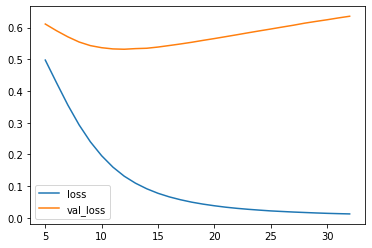

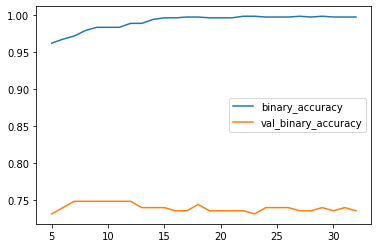

In [181]:
history = model_dl.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=18,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,
)

history_plt = pd.DataFrame(history.history)
history_plt.loc[5:, ['loss', 'val_loss']].plot()
history_plt.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_plt['val_loss'].min(), 
              history_plt['val_binary_accuracy'].max()))

Not great. I thought that Neural Networks should solve any problem, why are they getting such poor results. Well, I think (might be wrong here) that it comes from the nature of the text. It is important to remember what came before the word you are just reading. In other words – words by their selves don't carry a lot of meaning, but sentences do, that's why we need to analyse whole sentences, and for this purpose, we will use Recurent Neural Networks.

## Let's try with different nerual net

In [194]:
time_step = 8

model_rc = keras.Sequential()
model_rc.add(SimpleRNN())

NameError: name 'SimpleRNN' is not defined